In [ ]:
"""
AI Usage Statement (Dan LaChance)
Tools Used: ChatGPT
    - Usage: Graphing
    - Verification: Gave Chat the algorithm and only had it produce the code based on my instruction; manually input the code
Prohibited Use Compliance: Confirmed

This script is modifed based on Han's autoencoder by editing the testing set to only include samples from the Thursday set. 
"""

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras import models
import pickle


In [ ]:
"""
Load and preprocess data from test set: Thursday and train/validation set: Friday
"""
# sepcify the file path for the processed data
DATA_DIR = "./processed_friday_data"
TEST_DIR = "./processed_thursday_data"
# get the processed data X_train, X_val, X_test, y_test
train_df = pd.read_csv(f"{DATA_DIR}/X_train.csv")
val_df   = pd.read_csv(f"{DATA_DIR}/X_val.csv")
test_df  = pd.read_csv(f"{TEST_DIR}/X_val.csv")
y_test   = pd.read_csv(f"{TEST_DIR}/y_val.csv").iloc[:, 0]
X_val_mix = val_df.drop(columns=["Label"])
Y_val_mix = val_df["Label"]

# collapse all non-benign labels to generic “Attack”
y_test_bin = (y_test != "Benign").astype(int).values   # 0 = Benign, 1 = Attack


In [ ]:
"""
Label all benign samples for training and validation sets, then drop the label column
"""

# seperate the benign sampels from the training and validaion datasets
train_benign = train_df[train_df["Label"] == "Benign"]
val_benign   = val_df  [val_df  ["Label"] == "Benign"]
# remove the label column and extract only the features into numpy arrays
X_train_raw = train_benign.drop(columns=["Label"]).values
X_val_raw   = val_benign.drop(columns=["Label"]).values
X_test_raw  = test_df.values
X_val_mix_raw = X_val_mix.values


In [ ]:
""" 
Impute missing values in the training set using the median of each column
"""

# replace any infinite values with nan
# Simple IMputer cannot handle inf but it can handle nan
print("Handle infinite values")
X_test_raw[np.isinf(X_test_raw)] = np.nan

# use simpleimputer function to replace missing values with the median value of each column
imp = SimpleImputer(strategy="median").fit(X_test_raw)
X_test_imp = imp.transform(X_test_raw)

# Use scaler to learn the min max values but only for the training data
scaler = MinMaxScaler().fit(X_test_imp)
X_test = scaler.transform(X_test_imp)

print(f"Test shape: {X_test.shape}")


Handle infinite values
Test shape: (87, 49)


best thr: 0.013356443335764965
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Classification Report (Benign = 0, Attack = 1):
              precision    recall  f1-score   support

           0      0.786     0.190     0.306        58
           1      0.356     0.897     0.510        29

    accuracy                          0.425        87
   macro avg      0.571     0.543     0.408        87
weighted avg      0.643     0.425     0.374        87


Readable Confusion Matrix:
                    Predicted: Benign (0)  Predicted: Attack (1)
Actual: Benign (0)                     11                     47
Actual: Attack (1)                      3                     26


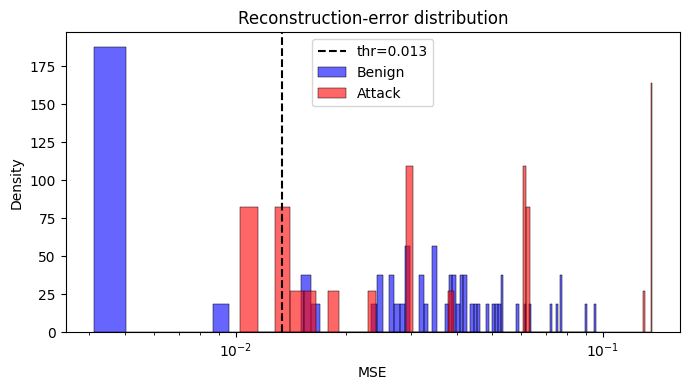

In [ ]:
"""
This block is ran after model is tuned using validation set.
Load the best threshold from the previous model tuning process.
The threshold is used to classify the test set samples as benign or attack based on the reconstruction error.
"""

with open("best_threshold_93.pkl", "rb") as f:
    best_thr = pickle.load(f)

print(f"best thr: {best_thr}")

auto_loaded = models.load_model("denoising_autoencoder_model_93.h5", compile=False)

test_err = np.mean((auto_loaded.predict(X_test) - X_test) ** 2, axis=1)
y_pred = (test_err > best_thr).astype(int)

# Classification report
print("\nClassification Report (Benign = 0, Attack = 1):")
print(classification_report(y_test_bin, y_pred, digits=3))

# Confusion matrix
conf_mat = confusion_matrix(y_test_bin, y_pred)
conf_df = pd.DataFrame(
    conf_mat,
    index=["Actual: Benign (0)", "Actual: Attack (1)"],
    columns=["Predicted: Benign (0)", "Predicted: Attack (1)"]
)
print("\nReadable Confusion Matrix:")
print(conf_df)

# Plot
plt.figure(figsize=(7, 4))
sns.histplot(test_err[y_test_bin == 0], bins=100, stat="density",
             label="Benign", color="blue", alpha=0.6)
sns.histplot(test_err[y_test_bin == 1], bins=100, stat="density",
             label="Attack", color="red", alpha=0.6)
plt.axvline(best_thr, ls="--", c="k", label=f"thr={best_thr:.2g}")
plt.xscale("log")
plt.legend()
plt.title("Reconstruction-error distribution")
plt.xlabel("MSE")
plt.tight_layout()
plt.show()